# Combustion Chemistry in Isobaric Reactor: Analyzing the Principal Components of the $R_{H}$ Data Matrix

In [1]:
### Importing Libraries

import sys
print(sys.version)
import os
import time


### Defining WORKSPACE_PATH

# WORKSPACE_PATH = os.environ['WORKSPACE_PATH']
WORKSPACE_PATH = os.path.join(os.getcwd(), '../../../../../')
ROMNet_fld     = os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/')


### Importing External Libraries

import numpy                             as np
import pandas                            as pd
pd.options.mode.chained_assignment = None  # default='warn'


### Importing Matplotlib and Its Style

import matplotlib.pyplot                 as plt

#plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/presentation.mplstyle'))
#plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/zoomed.mplstyle'))
plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/paper_1column.mplstyle'))
#plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/paper_2columns.mplstyle'))


from scipy.integrate import solve_ivp
import pyDOE    
from PCAfold         import PCA          as PCAA

# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:80% !important; }</style>"))

3.9.12 (main, Mar 26 2022, 15:51:13) 
[Clang 12.0.0 (clang-1200.0.32.29)]


Missing colon in file PosixPath('/Users/sventur/.matplotlib/stylelib/paper_2columns.mplstyle'), line 1 ('f#### MATPLOTLIBRC FORMAT')


## Defining Input Variables

In [2]:
DataDir            = os.path.join(WORKSPACE_PATH, 'ROMNet/Data/0DReact_Isobaric_500Cases_H2/')
FigDir             = None #os.path.join(WORKSPACE_PATH, '../Desktop/Paper_Figures_DeepONet_/')

tStratch           = 1.
SOLVER             = 'BDF'

valid_perc         = 20.

FixedMinVal        = 1.e-32

DRAlgo             = 'KPCA'

VarName            = 'H'
VarLabel           = '$H$'

if (VarName == 'All'):
    NModesFinal    = 16
    DRType         = 'All'
else:
    NModesFinal    = 16
    DRType         = 'OneByOne'
    
    
ColorVec           = ['#190707', '#dd3232', '#0065a9', '#348a00','#985396','#f68b69']

try:
    os.makedirs(DataDir)
except OSError as e:
    pass
try:
    os.makedirs(DataDir+'/Orig/'+str(PCAType))
except:
    pass

In [3]:
FileName   = DataDir + '/Orig//train/ext/CleanVars.csv'
Vars       = pd.read_csv(FileName, delimiter=',', header=None).to_numpy()[0,:]
NVars      = len(Vars)

iVar       = list(Vars).index(VarName)

In [4]:
FileName     = DataDir + '/Orig/train/ext/ICs.csv'
Data         = pd.read_csv(FileName)
ICVecs       = Data.to_numpy()
n_ics        = len(ICVecs)

In [5]:
if (DRType == 'All'):
    
    Cols   = []
    NewFlg = True
    for iC in range(n_ics):


        FileName             = DataDir+'/Orig/train/ext/y.csv.'+str(iC+1)
        Data                 = pd.read_csv(FileName, header=0)
        DataTemp             = Data[[Vars[iVar] for iVar in range(NVars)]]
        DataTemp             = np.maximum(DataTemp, FixedMinVal)


        Flg = True
        for iVar in range(NModesFinal):
            if (np.abs( (DataTemp[Vars[iVar]][0] - DataTemp[Vars[iVar]][len(Data)-1])/DataTemp[Vars[iVar]][0] ) < 1.e-6): 
                Flg = False
                break
        
        if Flg:
            DataICTemp  = Data[[Vars[iVar] for iVar in range(NVars)]].iloc[0]
            
            if (NewFlg):
                DataInput        = DataTemp
                DataIC           = DataICTemp
                NewFlg           = False
            else:
                DataInput        = pd.concat([DataInput, DataTemp], axis=1)
                DataIC           = pd.concat([DataIC, DataICTemp], axis=1)
            Cols += [str(iC+1)+'_'+str(iVar+1) for iVar in range(NVars)]
            
        else:
            print('iC ', iC)

    tVec              = Data['t']
    DataInput.columns = Cols
    
    yMat              = DataInput.to_numpy()
    
else:
    
    Cols   = []
    NewFlg = True
    for iC in range(n_ics):



        FileName             = DataDir+'/Orig/train/ext/y.csv.'+str(iC+1)
        Data                 = pd.read_csv(FileName, header=0)
        DataTemp             = np.maximum(Data[Vars[iVar]], FixedMinVal)

        if (np.abs( (DataTemp[0] - DataTemp[len(Data)-1])/DataTemp[0] ) > 1.e-6):
            DataICTemp  = Data[[Vars[iVar] for iVar in range(NVars)]].iloc[0]
            
            if (NewFlg):
                DataInput        = DataTemp
                DataIC           = DataICTemp
                NewFlg           = False
            else:
                DataInput        = pd.concat([DataInput, DataTemp], axis=1)
                DataIC           = pd.concat([DataIC, DataICTemp], axis=1)
            Cols.append(str(iC+1))

    tVec              = Data['t']
    DataInput.columns = Cols

    yMat              = DataInput.to_numpy()
    
DataIC            = DataIC.T.reset_index(drop=True, inplace=False)

In [6]:
ICs = DataIC.to_numpy()

In [7]:
yMat.shape

(1000, 500)

In [8]:
C = yMat.mean(axis=0)
D = yMat.std(axis=0)

def Norm(yMat, C, D):
    return ( yMat - C ) / D
    #return ( yMat - C ) 
    
def NormInv(yMatt, C, D):
    return yMatt * D + C 
    #return yMatt + C 


yMatt = Norm(yMat, C, D)

In [9]:
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import FastICA



NPCA      = 16

# PCA_      = PCA(n_components=NPCA, )
# yMat_PCA  = PCA_.fit_transform(yMatt)
# yMat_1    = PCA_.inverse_transform(yMat_PCA)
# yMat_1    = NormInv(yMat_1, C, D)

pca        = PCAA(yMatt, scaling='none', n_components=NPCA, nocenter=True)
C          = pca.X_center
D          = pca.X_scale
A          = pca.A[:,0:NPCA].T
L          = pca.L
LL         = np.maximum(L,0.)
AT         = A.T
yMat_PCA   = yMatt.dot(AT)
yMat_1     = yMat_PCA.dot(A)
yMat_1     = NormInv(yMat_1, C, D)

print(' ' )
print('[PCA] Shape of yMat_pca = ', yMat_PCA.shape)
print('[PCA]  Max % Error = ', np.max(abs((yMat - yMat_1)/yMat)*100))
print('[PCA]  Max      SE = ', np.max((yMat - yMat_1)**2))
print('[PCA] Mean % Error = ', np.mean(abs((yMat - yMat_1)/yMat)*100))
print('[PCA]          MSE = ', np.mean((yMat - yMat_1)**2))




NIPCA     = 16

IPCA_     = FastICA(n_components=NIPCA)
yMat_IPCA = IPCA_.fit_transform(yMatt)
yMat_2    = IPCA_.inverse_transform(yMat_IPCA)
yMat_2    = NormInv(yMat_2, C, D)

print(' ' )
print('[IPCA] Shape of yMat_pca = ', yMat_IPCA.shape)
print('[IPCA]  Max % Error = ', np.max(abs((yMat - yMat_2)/yMat)*100))
print('[IPCA]  Max      SE = ', np.max((yMat - yMat_2)**2))
print('[IPCA] Mean % Error = ', np.mean(abs((yMat - yMat_2)/yMat)*100))
print('[IPCA]          MSE = ', np.mean((yMat - yMat_2)**2))



NKPCA     = 16

#KPCA_     = KernelPCA(n_components=NKPCA, kernel='rbf', degree=5, alpha=0.0001, fit_inverse_transform=True)
KPCA_     = KernelPCA(n_components=NKPCA, kernel='poly', degree=4, alpha=0.001, fit_inverse_transform=True)
yMat_KPCA = KPCA_.fit(yMatt).transform(yMatt)
yMat_3    = KPCA_.inverse_transform(yMat_KPCA)
yMat_3    = NormInv(yMat_3, C, D)

print(' ' )
print('[KPCA] Shape of yMat_pca = ', yMat_KPCA.shape)
print('[KPCA]  Max % Error = ', np.max(abs((yMat - yMat_3)/yMat)*100))
print('[KPCA]  Max      SE = ', np.max((yMat - yMat_3)**2))
print('[KPCA] Mean % Error = ', np.mean(abs((yMat - yMat_3)/yMat)*100))
print('[KPCA]          MSE = ', np.mean((yMat - yMat_3)**2))

 
[PCA] Shape of yMat_pca =  (1000, 16)
[PCA]  Max % Error =  1.5174304786909928e+30
[PCA]  Max      SE =  3.4185961999988233e-05
[PCA] Mean % Error =  1.8677726295219584e+26
[PCA]          MSE =  3.123559200728933e-08
 
[IPCA] Shape of yMat_pca =  (1000, 16)
[IPCA]  Max % Error =  1.517430081161503e+30
[IPCA]  Max      SE =  3.418596415148445e-05
[IPCA] Mean % Error =  1.867772865055043e+26
[IPCA]          MSE =  3.1235592728001715e-08
 
[KPCA] Shape of yMat_pca =  (1000, 16)
[KPCA]  Max % Error =  1.1310341978632965e+29
[KPCA]  Max      SE =  1.751510593838179e-05
[KPCA] Mean % Error =  4.613458709657204e+24
[KPCA]          MSE =  2.0818287275593527e-09


In [10]:
yMat

array([[1.00000000e-32, 1.00000000e-32, 1.00000000e-32, ...,
        1.00000000e-32, 1.00000000e-32, 1.00000000e-32],
       [1.36111894e-07, 1.87239378e-08, 4.99223501e-08, ...,
        1.57463280e-07, 4.93031244e-09, 4.19607014e-09],
       [1.38475637e-07, 1.90364310e-08, 5.07558727e-08, ...,
        1.60217854e-07, 5.01144038e-09, 4.26496171e-09],
       ...,
       [2.96177386e-03, 2.60840970e-03, 1.38574523e-03, ...,
        3.62139552e-03, 2.13472399e-03, 2.12003217e-03],
       [2.96177386e-03, 2.60840970e-03, 1.38574523e-03, ...,
        3.62139552e-03, 2.13472399e-03, 2.12003217e-03],
       [2.96177386e-03, 2.60840970e-03, 1.38574523e-03, ...,
        3.62139552e-03, 2.13472399e-03, 2.12003217e-03]])

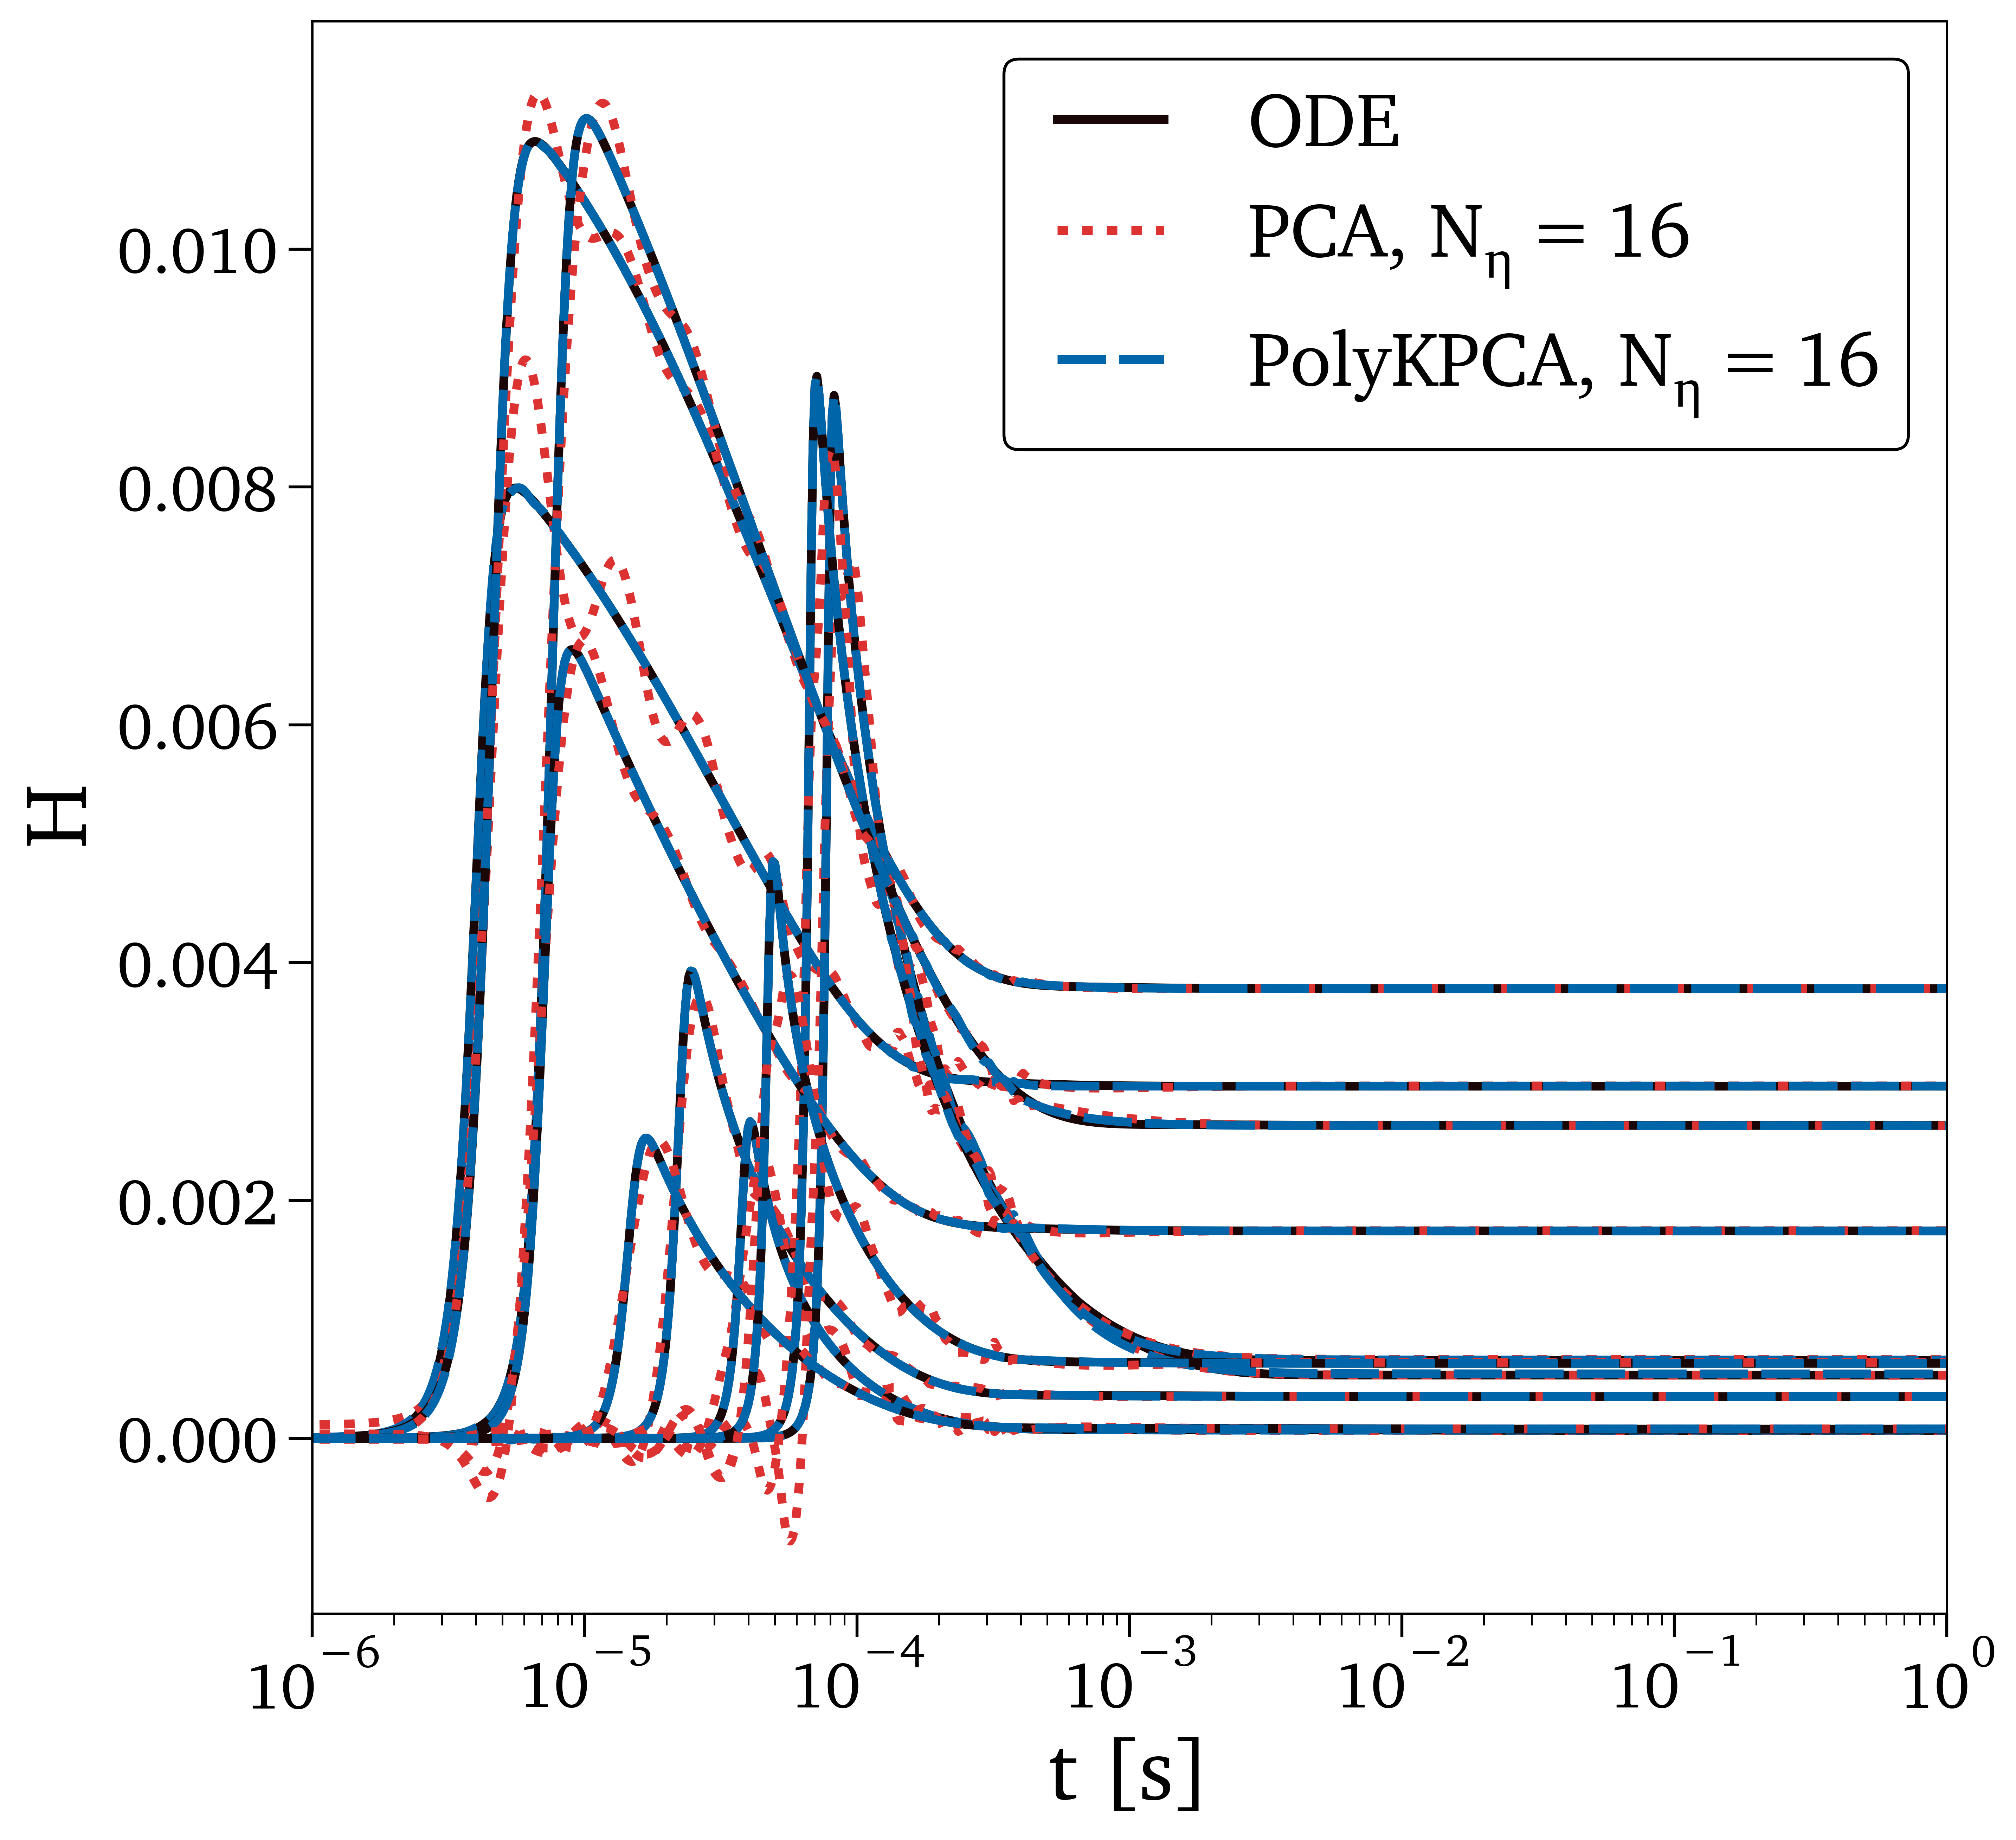

In [11]:
CaseVec   = np.arange(0,500,50)

for jCase, iCase in enumerate(CaseVec):

    if (jCase == 0):
        Label1 = r'ODE'
        Label2 = r'PCA, $N_{\eta}='+str(NPCA)+'$'
        #Label3 = r'IPCA, $N_{\eta}='+str(NPCA)+'$'
        Label4 = r'PolyKPCA, $N_{\eta}='+str(NKPCA)+'$'
    else:
        Label1 = None
        Label2 = None
        Label3 = None
        Label4 = None
        
    plt.plot(tVec, yMat[:,iCase],    '-', label=Label1, color=ColorVec[0])
    plt.plot(tVec, yMat_1[:,iCase],  ':', label=Label2, color=ColorVec[1])
    #plt.plot(yMat_2[:,iCase],  '-', label=Label3, color=ColorVec[2])
    plt.plot(tVec, yMat_3[:,iCase], '--', label=Label4, color=ColorVec[2])

plt.xscale('log')
plt.xlabel('t [s]')
plt.ylabel(r''+VarLabel)
plt.xlim([1.e-6,1.e0])
plt.legend()

In [12]:
if   (DRAlgo == 'PCA'):
    yMat_DR  = yMat_PCA
elif (DRAlgo == 'IPCA'):
    yMat_DR  = yMat_IPCA
elif (DRAlgo == 'KPCA'):
    yMat_DR  = yMat_KPCA

In [13]:
stop

NameError: name 'stop' is not defined

In [ ]:
# from sklearn.manifold import Isomap
# from sklearn.manifold import LocallyLinearEmbedding
# from sklearn.manifold import MDS
# from sklearn.manifold import SpectralEmbedding



# NISO      = 10

# ISO_      = Isomap(n_components=NISO)
# yMat_ISO  = ISO_.fit(yMatt)
# yMat_ISO_ = ISO_.transform(yMatt)



# NLE       = 10

# LE_       = LocallyLinearEmbedding(n_components=NLE)
# yMat_LE   = LE_.fit(yMatt)
# yMat_LE_  = LE_.transform(yMatt)



# NMSD      = 10

# MSD_      = MDS(n_components=NMSD)
# yMat_MSD  = MSD_.fit_transform(yMatt)



# NSE       = 10

# embedding = SpectralEmbedding(n_components=NSE)
# yMat_SE   = embedding.fit_transform(yMatt)



# plt.plot(tVec, yMat_LE_[:,8])
# plt.xscale('log')

In [ ]:
Vars             = ['Eta_'+str(i_mode+1) for i_mode in range(NModesFinal)]
Data             = pd.DataFrame(yMat_DR, columns=Vars)
tVec[tVec == 0.] = FixedMinVal
Data['t']        = tVec
Data['log(t)']   = np.log(tVec)
Data['log10(t)'] = np.log10(tVec)


Data

In [ ]:
from sklearn.model_selection import train_test_split

try:
    os.makedirs(DataDir+'/'+str(NModesFinal)+DRAlgo+'/'+str(DRType)+'/'+VarName)
except:
    pass
try:
    os.makedirs(DataDir+'/'+str(NModesFinal)+DRAlgo+'/'+str(DRType)+'/'+VarName+'/Trunk/')
except:
    pass
try:
    os.makedirs(DataDir+'/'+str(NModesFinal)+DRAlgo+'/'+str(DRType)+'/'+VarName+'/Trunk/train/')
except:
    pass
try:
    os.makedirs(DataDir+'/'+str(NModesFinal)+DRAlgo+'/'+str(DRType)+'/'+VarName+'/Trunk/valid/')
except:
    pass
try:
    os.makedirs(DataDir+'/'+str(NModesFinal)+DRAlgo+'/'+str(DRType)+'/'+VarName+'/Trunk/test/')
except:
    pass

In [ ]:
data_id    = 'pts'

DataNoZero           = Data[Data['t'] >= FixedMinVal]
n_points             = len(DataNoZero)

idx                  = np.arange(n_points)
train_idx, valid_idx = train_test_split(idx, test_size=valid_perc/100, random_state=42)

n_valid              = len(valid_idx)
n_train              = len(train_idx)


try:
    os.makedirs(DataDir+'/'+str(NModesFinal)+DRAlgo+'/'+str(DRType)+'/'+VarName+'/Trunk/train/'+data_id+'/')
except:
    pass
try:
    os.makedirs(DataDir+'/'+str(NModesFinal)+DRAlgo+'/'+str(DRType)+'/'+VarName+'/Trunk/valid/'+data_id+'/')
except:
    pass

DataInput  = DataNoZero[['t', 'log10(t)', 'log(t)'] + Vars]
DataInput.iloc[train_idx].to_csv(DataDir+'/'+str(NModesFinal)+DRAlgo+'/'+str(DRType)+'/'+VarName+'/Trunk/train/'+data_id+'/Input.csv', index=False)
DataInput.iloc[valid_idx].to_csv(DataDir+'/'+str(NModesFinal)+DRAlgo+'/'+str(DRType)+'/'+VarName+'/Trunk/valid/'+data_id+'/Input.csv', index=False)

DataOutput = DataNoZero[['t', 'log10(t)', 'log(t)'] + Vars]
DataOutput.iloc[train_idx].to_csv(DataDir+'/'+str(NModesFinal)+DRAlgo+'/'+str(DRType)+'/'+VarName+'/Trunk/train/'+data_id+'/Output.csv', index=False)
DataOutput.iloc[valid_idx].to_csv(DataDir+'/'+str(NModesFinal)+DRAlgo+'/'+str(DRType)+'/'+VarName+'/Trunk/valid/'+data_id+'/Output.csv', index=False)

In [ ]:
DataNoZero